<h1><center>Email Spam Classifier - BERT</center></h1>

This project is based on Manning's book "Transfer Learning for NLP" (chapter 2).
The goal here is:

1. Curate a dataset with emails and spam consisting of random 1000 samples for each class
2. Extract from the emails only the text,i.e, no headers.
3. Create a simple bag-of-words model from the above content. Simple because it is based on term frequency (tf) only.
4. Choose one baseline classifier from Logistic Regression and Gradient Boosting Machine
5. Accuracy is the metric of choice as the dataset is balanced and consists of two classes
6. Train a SPAM classifier based on BERT embeddings

But before starting let's make sure we have the correct libraries versions installed, namelly tensorflow and bert-tensorflow.


In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
# Import requiered libraries
import pandas as pd
import numpy as np
import email
import os
import pickle

Define data file path, i.e., directory where data to train the classifier is. As this is a csv type,  the file is loaded with pandas read_csv function. If successfull the number of rows and columns with the first 5 rows are printed.

In [3]:
data_file_path = "/home/baosiek/Documents/deep_learning/transfer-learning/data/emails.csv"
emails = pd.read_csv(data_file_path)
print("Emails were loaded successfully containing {} rows and {} columns".format(emails.shape[0], emails.shape[1]))
print("Printing 5 first rows...")
print(emails.head(5))

Emails were loaded successfully containing 517401 rows and 2 columns
Printing 5 first rows...
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


Prints the contect of the first email, under the message column, enabling data understanding.

In [4]:
print(emails.loc[0, "message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


Lets get only the text part of the message, discarding date, from, to and Subject info. 

In [5]:
def extract_text(emails):

    # Initializes a list of texts where each row will contain only the content of the email
    contents = []
    
    for item in emails["message"]:
        e = email.message_from_string(item)
        content = e.get_payload() # Gets only a string with the email content
        contents.append(content)
        
    return contents

In [6]:
# This process may take sometime. So we first check if the emails were already
# processed with their respective content in a list. If this data is not found this 
# procedure extracts the content from the emails and stores it.
if not os.path.exists('/home/baosiek/Documents/deep_learning/transfer-learning/data/contents.txt'):
    contents = extract_text(emails)
    with open("./data/contents.txt", "wb") as fp:   # Serializing
        pickle.dump(contents, fp)
else:
    with open("./data/contents.txt", "rb") as fp:   # Deserializing
        contents = pickle.load(fp)
        

# Prints the content at row 100
print(contents[100])

I tried the new address but I don't have access.  also, what do I need to 
enter under domain?


Testing if number of rows in emails data frame and contents list data structure are equal. Could use assert

In [7]:
assert len(contents) == emails.shape[0], f'Contents extracted from email do not have the same shape. contents length=={len(contents)} and email.shape[0]=={emails.shape[0]}'

Converts contents list into a data frame and prints the first 5 emails contents

In [8]:
contents_df = pd.DataFrame(contents)
print(contents_df.head(n=5))

                                                   0
0                          Here is our forecast\n\n 
1  Traveling to have a business meeting takes the...
2                     test successful.  way to go!!!
3  Randy,\n\n Can you send me a schedule of the s...
4                Let's shoot for Tuesday at 11:45.  


# The Spam dataset

In [9]:
data_file_path = "/home/baosiek/Documents/deep_learning/transfer-learning/data/fradulent_emails.txt"
with open(data_file_path, 'r', encoding='latin1') as file:
    spams = file.read()
# spams is a long string beacause originally the data downloaded is a single text file.
# We need to find how to split this entire file into units where each one in a single email.
# So reading the downloaded file with Gedit we can conclude that each email starts with
# the char sequence "From r". So we will use this to split this big string into a list of emails.
# The reason why we associate to the final structure all emails from 1 and not 0 is because the 
# original file starts with 'From r' splitting it into an empty first element and the first email in
# the second elemnt of the spams list
spams = spams.split('From r')[1:]
print(f'Spams was successfully downloaded and contains {len(spams)} emails')

spams_df = extract_text(pd.DataFrame(spams, columns=['message']))
spams_df = pd.DataFrame(spams_df)
print(spams_df.head())

Spams was successfully downloaded and contains 3977 emails
                                                   0
0  FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1  Dear Friend,\n\nI am Mr. Ben Suleman a custom ...
2  FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3  FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4  Dear sir, \n \nIt is with a heart full of hope...


# Hyperparameters

Now lets create the dataset to train classifiers. It will contain n_samples from each data frame (emails and spams). Each sample will contain max_tokens and each token max_characters as hyperparameters to enable acceptable performance for training and classification.

In [10]:
n_samples = 1000 # number of samples frome each data frame
max_tokens = 50 # maximum number of tokens in each email
max_chars = 20 # maximum length of each token
threshold = 0.7 # percentage of training examples in the dataset

Function to tokenize emails

In [11]:
def tokenize(row):
    
    if row == None or row == '' or type(row) == list:
        tokens = ""
    else:
        tokens = row.split(" ")[:max_tokens]
        
    return tokens

Function to extract punctuations, lowercase all tokens anf limit token size

In [12]:
import re

def clean_text(token_list):
    
    tokens = []
    
    try:
        for token in token_list:
            token = token.lower()
            token = re.sub(r'[\W\d]', "", token)[:max_chars]
            tokens.append(token)
            
    except:
        tokens.append("")
        
    return tokens    

# Build dataframe with emails and spams.

Removing stopwords

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

def stopwords_removal(token_list):
    
    token = [token for token in token_list if token not in stopwords]
    token = filter(None, token)
    return token

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/baosiek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
real_emails = contents_df.iloc[:, 0]
real_emails = real_emails.apply(tokenize)
real_emails = real_emails.apply(stopwords_removal)
real_emails = real_emails.apply(clean_text)
real_emails = real_emails.sample(n_samples)
print(f'real_emails dataframe contains {real_emails.shape[0]} samples. Listing first 5...')
print(real_emails.head(n=5))

real_emails dataframe contains 1000 samples. Listing first 5...
216304    [i, would, like, invite, participate, conferen...
87331     [start, date, , hourahead, hour, , no, ancilla...
344974    [audrey, attached, term, sheet, barbara, gray,...
457102    [narsimhahave, look, this, have, using, correc...
514853    [please, let, know, questions, regarding, pric...
Name: 0, dtype: object


In [15]:
spam_emails = spams_df.iloc[:, 0]
spam_emails = spam_emails.apply(tokenize)
spam_emails = spam_emails.apply(stopwords_removal)
spam_emails = spam_emails.apply(clean_text)
spam_emails = spam_emails.sample(n_samples)
print(f'spam_emails dataframe contains {spam_emails.shape[0]} samples. Listing first 5...')
print(spam_emails.head(n=5))

spam_emails dataframe contains 1000 samples. Listing first 5...
2501                                                   []
2923    [froma, mrs, farah, alhashemiaddressa, chiang,...
1665    [kind, attention, sirci, martin, arap, moic, s...
3151    [greetings, dubaicthis, letter, must, come, bi...
698     [attn, the, presidentceo, i, mr, fred, mende, ...
Name: 0, dtype: object


Lets combine these two data frames into one NP array

In [16]:
data = pd.concat([spam_emails, real_emails], axis=0).values
print(f'data is a {type(data)}. Shape is {data.shape}.')
print(data[1])

data is a <class 'numpy.ndarray'>. Shape is (2000,).
['froma', 'mrs', 'farah', 'alhashemiaddressa', 'chiang', 'rai', 'hospital', 'chiang', 'rai', '', 'lampoon', 'rdccchiang', 'rai', 'thailanddearest', 'belovedcthank', 'attention', 'beeing', 'given', 'go', 'mailei', 'mrsefarah', 'alhashemic', 'the', 'wife', 'iraq', 'military', 'finance', 'corps', 'chiefc', 'incharge', 'payment', 'military', 'salary', 'life']


Creting labels to the emails in data. The first 1000 columsn [:1000] are real emails (label=1) and the last 1000 [1000:] are spams (label=0)

In [17]:
categories = ['spam''real']
labels = ([1]*n_samples) # spams
labels.extend(([0]*n_samples)) # emails

print(f'labels has shape {len(labels)}')
print(labels[:5]) # printing first 5 real labels
print(labels[100: 105]) # printing first spam labels

labels has shape 2000
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]


# Transfer Learning with BERT

Import all required libraries for tensorflow on CPU and keras. 
Besides importing these libraries I will make use of some helper functions to convert text into the format/features BERT expects.
Download from https://github.com/strongio/keras-bert keras-bert.py where appropriate. In my case at the root of this project.

In [18]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

# Making sure we have the correct tensorflow version
assert tf.__version__ == "1.15.0", 'Correct tensorflow version is 1.15.0'

Using TensorFlow backend.


Here we will use BERT.
Download from https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1 the model and store at /model directory.

In [19]:
assert tf.__version__ == "1.15.0"
    
# starting TF sessions and setting it to keras backend
sess = tf.Session()
K.set_session(sess)

# BERT layer

BertEmbeddingLayer below is practically a copy from the class BertLayer defined in keras-bert.py. As I am saving the trained model, in case it does not already exists, there is the need to define 'def get_config(self)' to enable saving it. I decided to do it below and changed slitly the names just to better understand the nuts and bolts of it.

In [20]:
sess = tf.Session()

class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self,
        n_fine_tune_layer = 10,
        pooling = 'mean',
        bert_path = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1',
        **kwargs
    ):

        self.n_fine_tune_layer = n_fine_tune_layer
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path

        super(BertEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_features):

        self.bert_layer = hub.Module(
            self.bert_path, trainable=self.trainable, name=f'{self.name}_module')

        print(type(self.bert_layer))

        trainable_vars = self.bert_layer.variables
        
        if self.pooling == 'first':
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]
        elif self.pooling == 'mean':
            trainable_vars = [
                var for var in trainable_vars
                if not "/cls/" in var.name 
                and not "/pooler/" in var.name]

            trainable_layers = []
        else:
            raise NameError('Undefined pooling type')

        for i in range(self.n_fine_tune_layer):
            trainable_layers.append(f'encoder/layer_{str(11 - i)}')

        trainable_vars = [
            var for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert_layer.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertEmbeddingLayer, self).build(input_features)

    def call(self, inputs):
        inputs = [K.cast(x, dtype='int32') for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)

        if self.pooling == 'first':
            pooled = self.bert_layer(
                inputs=bert_inputs, signature='tokens', as_dict=True)['pooled_output']

        elif self.pooling == 'mean':
            result = self.bert_layer(
                inputs=bert_inputs, signature='tokens', as_dict=True)['sequence_output']

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (tf.reduce_sum(m, axis=1, keep_dims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)

        else:
            raise NameError('Undefined pooling type')

        return pooled

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_fine_tune_layer': self.n_fine_tune_layer,
            'pooling': self.pooling,
            'bert_path': self.bert_path,
        })
        return config

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)
            


Before preparing data to the format expected by BERT I am going to convert data format from where each email consistes in a list of tokens to another where each email consists of one string. Starting this process from the already processed data is due to the fact that in the latter, token were alredy filtered for punctuation, stopwords, lowercase, etc. 

In [21]:
def convert_data_to_bert_feature_format(x, y):

    converted_data, converted_labels = [], []
    
    # From list of tokens to one string
    for index in range(x.shape[0]):
        text = ' '.join(x[index])
        converted_data.append(text)
        converted_labels.append(y[index])

    # Converted_data to np.array
    converted_data = np.array(converted_data, dtype=object)[:, np.newaxis]

    return converted_data, np.array(converted_labels)

data, labels = convert_data_to_bert_feature_format(data, labels)

print(f'{data[2]} -> {labels[2]}')

['kind attention sirci martin arap moic son the former president kenyamr daniel arap moie i came know course mysearch reliable and god fearing partnerc i decided contact youcbecause i believe reputable person'] -> 1


In [22]:
idx = int(data.shape[0]*threshold)
train_x, train_y = data[:idx], labels[:idx]
test_x, test_y = data[idx:], labels[idx:]

print(f'train_x shape: {train_x.shape}, train_y shape: {train_y.shape}')
print(f'test_x shape: {test_x.shape}, test_y shape: {test_y.shape}')

train_x shape: (1400, 1), train_y shape: (1400,)
test_x shape: (600, 1), test_y shape: (600,)


In [23]:
def build_model(max_seq_length):

    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name='input_ids')
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name='input_masks')
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name='segment_ids')
    bert_layer_inputs = [in_id, in_mask, in_segment]

    bert_output = BertEmbeddingLayer(n_fine_tune_layer=0)(bert_layer_inputs)
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=bert_layer_inputs, outputs=output)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [24]:
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

At the time of developing this notebook bert-tensorflow version 1.0.4 had an opened issue (https://github.com/google-research/bert/issues/1133). I had to downgrade it, as guided in the reffered issue, to version 1.0.1.

In [25]:
from tqdm import tqdm
import kerasBert as kb
import bert.tokenization as tk
from tensorflow_hub import Module
import pkg_resources as pkg
import bert_utils as bu

# Making sure we have install the correct libraries.
assert pkg.get_distribution("bert-tensorflow").version == '1.0.1', 'Change bert-tensorflow version to 1.0.1'

vocab_file_path = '/home/baosiek/Documents/deep_learning/transfer-learning/model/bert/assets/vocab.txt'
tokenizer = bu.create_tokenizer(vocab_file_path)

train_examples = kb.convert_text_to_examples(train_x, train_y)
test_examples = kb.convert_text_to_examples(test_x, test_y)

(train_input_ids, train_input_masks, train_segment_ids, train_labels) = kb.convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_tokens)

(test_input_ids, test_input_masks, test_segment_ids, test_labels) = kb.convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_tokens)


Converting examples to features: 100%|██████████| 600/600 [00:00<00:00, 1515.00it/s]


I want to save the best model during training. Here I define best as the one with best validation accuracy. For that i will define three callbacks: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [26]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('model/bert/bert_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

Loading trained model!
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
<class 'tensorflow_hub.module.Module'>
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


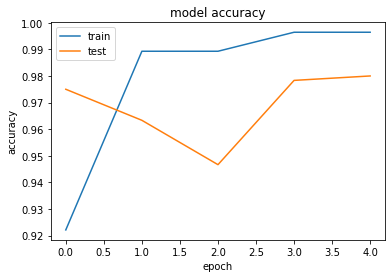

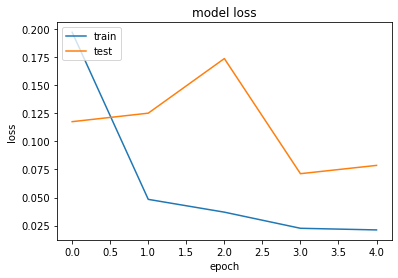

--------------------------------
Applying classifier on examples:
--------------------------------
This is an email: is SPAM!
The Royal family lives at Buckingham Palace: is SPAM!
Let's schedule the meeting to 2:00PM EST: is an EMAIL!
Buy your Diesel watch today and get a 10'%' discount: is an EMAIL!


In [29]:
import os
import matplotlib.pyplot as plt

# Will train only if bert_model.h5 does not exi
if not os.path.exists('model/bert/bert_model.hdf5'):
    print('Build and training model!')
    model = build_model(max_tokens)

    # Initialize keras.backend==tensorflow session
    initialize_vars(sess)

    # Fitting the model
    history = model.fit([train_input_ids, train_input_masks, train_segment_ids], train_labels, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels), epochs=5, batch_size=32)

    # Saving history dictionary
    history_dict = history.history
    tf.keras.models.save_model(model, 'model/bert/bert_model.hdf5')
    with open('model/bert/train_history_dict', 'wb') as file_pi:
        pickle.dump(history_dict, file_pi)
else:
    print('Loading trained model!')
    model = tf.keras.models.load_model('model/bert/bert_model.hdf5', {'BertEmbeddingLayer': BertEmbeddingLayer})
    with open("model/bert/train_history_dict", "rb") as fp:
        history_dict = pickle.load(fp)

# ploting history for accuracy and loss
plt.plot(history_dict['acc'])
plt.plot(history_dict['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ploting history for loss
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Now lets see examples working
print('--------------------------------')
print('Applying classifier on examples:')
print('--------------------------------')

text_examples = ['This is an email', 'The Royal family lives at Buckingham Palace', 'Let\'s schedule the meeting to 2:00PM EST', 'Buy your Diesel watch today and get a 10\'%\' discount']

# Here I am classifying messages one at a time just to work with different helper functions.
# This could be dealt as we did with training however,i.e., using kb.convert_text_to_examples
# and then kb.convert_examples_to_features.

for text_example in text_examples:
    # example should be an instance of class InputExample in keras-bert.py
    example = kb.InputExample(None, text_example)

    # helpser methos from keras-bert.py
    (example_input_id, example_input_mask, example_segment_id, example_label) = kb.convert_single_example(tokenizer, example, max_seq_length=max_tokens)

    # predicting
    predict = model.predict([np.reshape(example_input_id, (1, len(example_input_id))), np.reshape(example_input_mask, (1, len(example_input_mask))), np.reshape(example_segment_id, (1, len(example_segment_id)))])
    if predict[0] < 0.5:
        print(f'{example.text_a}: is an EMAIL!')
    else:
        print(f'{example.text_a}: is SPAM!')

Classifiying an email as SPAM or not does not seem to be a hard problem for LogisticRegression, ELMo or BERT. In fact even Naive Bayes and ME models perform well considering accuracy achieved. Nevertheless the messages at the end seems to be badly classified. 'Buy your Diesel watch today and get a 10'%' discount' is not a SPAM?

In [28]:
# os._exit(00)